In [31]:
# ============================================
# LIBRERÍAS NECESARIAS
# ============================================

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    classification_report, 
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Cargar dataset limpio sin outliers
archivo = "data_no_outliers.csv"
df = pd.read_csv(archivo)

print(f"Datos cargados correctamente desde '{archivo}'")
print(f"Total de registros: {len(df)}")
print(f"Columnas disponibles: {df.columns.tolist()}")
print("\n" + "="*70)
print("PRIMERAS FILAS DEL DATASET")
print("="*70)
display(df.head())

Datos cargados correctamente desde 'data_no_outliers.csv'
Total de registros: 292
Columnas disponibles: ['id_paciente', 'nombre', 'rut', 'Edad', 'fecha_registro', 'id_medico', 'FamiliarPrimerGradoCC', 'FamiliarSegundoGradoCC', 'DiagnosticoPrevioCancer', 'Ejercicio', 'Alcohol', 'Mamografia', 'Menstruacion', 'PrimerHijo', 'riesgo', 'Edad_Original']

PRIMERAS FILAS DEL DATASET


,id_paciente,nombre,rut,Edad,fecha_registro,id_medico,FamiliarPrimerGradoCC,FamiliarSegundoGradoCC,DiagnosticoPrevioCancer,Ejercicio,Alcohol,Mamografia,Menstruacion,PrimerHijo,riesgo,Edad_Original
0,926,Bridie,53581753,3,09/10/2025,1,0.0,1,1,1,1.0,0,NaN,1.0,Alto,79
1,109,Bellina,88983746,0,09/10/2025,1,0.0,0,0,2,2.0,0,NaN,1.0,Alto,29
2,295,Starla,2366096,2,09/10/2025,1,1.0,0,0,2,0.0,0,NaN,NaN,Alto,54
3,976,Celine,90902307,3,09/10/2025,1,1.0,1,1,2,2.0,0,NaN,0.0,Moderado,79
4,735,Pietra,66433625,3,09/10/2025,1,1.0,1,1,1,2.0,1,NaN,1.0,Bajo,61


In [32]:
# ============================================
# RECALCULAR PUNTAJE Y RIESGO
# ============================================

print("\nRecalculando Puntaje y Riesgo basado en factores clínicos...")

def calcular_puntaje(fila):
    """
    Calcula un puntaje de riesgo basado en factores de riesgo conocidos
    para cáncer de mama según literatura médica.
    """
    puntaje = 0
    
    def safe_value(value, default=0):
        """Maneja valores NaN de forma segura"""
        return default if pd.isna(value) else int(value)
    
    # Edad (factor de riesgo progresivo)
    edad_cat = safe_value(fila.get('Edad', 0))
    puntaje += [0, 5, 12, 20][min(edad_cat, 3)]
    
    # Antecedentes familiares (factores genéticos)
    puntaje += 25 if fila.get('FamiliarPrimerGradoCC', 0) == 1 else 0
    puntaje += 4 if fila.get('FamiliarSegundoGradoCC', 0) == 1 else 0
    
    # Diagnóstico previo (factor de riesgo muy alto)
    puntaje += 30 if fila.get('DiagnosticoPrevioCancer', 0) == 1 else 0
    
    # Menstruación temprana (mayor exposición a estrógenos)
    men_cat = safe_value(fila.get('Menstruacion', 1), 1)
    puntaje += [6, 3, 0][min(men_cat, 2)]
    
    # Primer embarazo tardío o nulípara
    hijo_cat = safe_value(fila.get('PrimerHijo', 1), 1)
    puntaje += [0, 5, 8][min(hijo_cat, 2)]
    
    # Ejercicio (factor protector)
    ej_cat = safe_value(fila.get('Ejercicio', 1), 1)
    puntaje += [5, 3, -2, -5][min(ej_cat, 3)]
    
    # Alcohol (factor de riesgo)
    alc_cat = safe_value(fila.get('Alcohol', 1), 1)
    puntaje += [0, 2, 5, 8][min(alc_cat, 3)]
    
    # Mamografía regular (detección temprana)
    puntaje += -3 if fila.get('Mamografia', 0) == 1 else 0
    
    return puntaje

# Aplicar función de puntaje
df['Puntaje'] = df.apply(calcular_puntaje, axis=1)

def clasificar_riesgo(puntaje):
    """
    Clasifica el puntaje en categorías de riesgo:
    0 = Bajo, 1 = Moderado, 2 = Alto
    """
    if puntaje < 20:
        return 0  # Bajo
    elif puntaje < 50:
        return 1  # Moderado
    else:
        return 2  # Alto

df['Riesgo'] = df['Puntaje'].apply(clasificar_riesgo)

print("Puntajes calculados correctamente")
print("\nESTADÍSTICAS DE PUNTAJE:")
print(df['Puntaje'].describe())

print("\nDISTRIBUCIÓN DE CLASES DE RIESGO:")
distribucion = df['Riesgo'].value_counts().sort_index()
for riesgo, cantidad in distribucion.items():
    etiqueta = ['Bajo', 'Moderado', 'Alto'][riesgo]
    porcentaje = (cantidad / len(df)) * 100
    print(f"  Riesgo {riesgo} ({etiqueta}): {cantidad} pacientes ({porcentaje:.1f}%)")


Recalculando Puntaje y Riesgo basado en factores clínicos...
Puntajes calculados correctamente

ESTADÍSTICAS DE PUNTAJE:
count    292.000000
mean      52.373288
std       22.338255
min       -5.000000
25%       36.750000
50%       52.000000
75%       68.000000
max      103.000000
Name: Puntaje, dtype: float64

DISTRIBUCIÓN DE CLASES DE RIESGO:
  Riesgo 0 (Bajo): 27 pacientes (9.2%)
  Riesgo 1 (Moderado): 105 pacientes (36.0%)
  Riesgo 2 (Alto): 160 pacientes (54.8%)


In [33]:
# ============================================
# SELECCIÓN DE VARIABLES PREDICTORAS
# ============================================

# Definir variables predictoras (features)
columnas_predictoras = [
    'Edad',
    'FamiliarPrimerGradoCC',
    'FamiliarSegundoGradoCC',
    'DiagnosticoPrevioCancer',
    'Menstruacion',
    'PrimerHijo',
    'Ejercicio',
    'Alcohol',
    'Mamografia'
]

# Verificar existencia de columnas
columnas_existentes = [c for c in columnas_predictoras if c in df.columns]
columnas_faltantes = [c for c in columnas_predictoras if c not in df.columns]

if columnas_faltantes:
    print(f"Advertencia: Columnas faltantes: {columnas_faltantes}")

print(f"Variables predictoras utilizadas ({len(columnas_existentes)}):")
for col in columnas_existentes:
    print(f"  - {col}")

# Preparar matriz de características (X) y vector objetivo (y)
X = df[columnas_existentes].copy()
y = df['Riesgo'].copy()

print(f"\nDimensiones de X (características): {X.shape}")
print(f"Dimensiones de y (objetivo): {y.shape}")

# Verificar balance de clases
print("\nBALANCE DE CLASES:")
for clase, cantidad in y.value_counts().sort_index().items():
    porcentaje = (cantidad / len(y)) * 100
    print(f"  Clase {clase}: {cantidad} ({porcentaje:.1f}%)")

Variables predictoras utilizadas (9):
  - Edad
  - FamiliarPrimerGradoCC
  - FamiliarSegundoGradoCC
  - DiagnosticoPrevioCancer
  - Menstruacion
  - PrimerHijo
  - Ejercicio
  - Alcohol
  - Mamografia

Dimensiones de X (características): (292, 9)
Dimensiones de y (objetivo): (292,)

BALANCE DE CLASES:
  Clase 0: 27 (9.2%)
  Clase 1: 105 (36.0%)
  Clase 2: 160 (54.8%)


In [34]:
# ============================================
# DIVISIÓN DEL DATASET (TRAIN/TEST)
# ============================================

# Verificar si hay suficientes datos para división
if len(df) < 10:
    print("Dataset muy pequeño. Se usará el mismo conjunto para train y test.")
    X_train, X_test = X, X
    y_train, y_test = y, y
else:
    # Verificar si se puede hacer estratificación
    min_clase = y.value_counts().min()
    
    if min_clase < 2:
        print("Alguna clase tiene solo 1 muestra. División sin estratificación.")
        stratify_param = None
    else:
        stratify_param = y
    
    # División 80% entrenamiento, 20% prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=stratify_param
    )
    
    print("Dataset dividido exitosamente")
    print(f"  - Entrenamiento: {len(X_train)} muestras ({len(X_train)/len(X)*100:.1f}%)")
    print(f"  - Prueba: {len(X_test)} muestras ({len(X_test)/len(X)*100:.1f}%)")
    
    print("\nDISTRIBUCIÓN EN CONJUNTO DE ENTRENAMIENTO:")
    for clase, cantidad in y_train.value_counts().sort_index().items():
        print(f"  Clase {clase}: {cantidad}")
    
    print("\nDISTRIBUCIÓN EN CONJUNTO DE PRUEBA:")
    for clase, cantidad in y_test.value_counts().sort_index().items():
        print(f"  Clase {clase}: {cantidad}")

Dataset dividido exitosamente
  - Entrenamiento: 233 muestras (79.8%)
  - Prueba: 59 muestras (20.2%)

DISTRIBUCIÓN EN CONJUNTO DE ENTRENAMIENTO:
  Clase 0: 21
  Clase 1: 84
  Clase 2: 128

DISTRIBUCIÓN EN CONJUNTO DE PRUEBA:
  Clase 0: 6
  Clase 1: 21
  Clase 2: 32


In [37]:
# ============================================
# LIMPIEZA FINAL Y PREPROCESAMIENTO
# ============================================

print("VERIFICACIÓN Y LIMPIEZA DE DATOS")
print("="*70)

# Verificar valores nulos
print("\nValores nulos por columna:")
nulos_train = X_train.isnull().sum()
if nulos_train.sum() > 0:
    print(nulos_train[nulos_train > 0])
else:
    print("  No hay valores nulos")

# Reemplazar infinitos por NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Función para obtener moda de forma segura
def obtener_moda_segura(serie, valor_defecto=0):
    """Obtiene la moda de una serie, o devuelve valor por defecto"""
    try:
        moda = serie.mode()
        return moda[0] if len(moda) > 0 else valor_defecto
    except:
        return valor_defecto

# Estrategia de imputación basada en la moda
valores_imputacion = {}
for col in X_train.columns:
    if X_train[col].isnull().sum() > 0:
        valores_imputacion[col] = obtener_moda_segura(X_train[col], 0)

print(f"\nValores de imputación calculados: {len(valores_imputacion)} columnas")

# Aplicar imputación
X_train = X_train.fillna(valores_imputacion if valores_imputacion else 0)
X_test = X_test.fillna(valores_imputacion if valores_imputacion else 0)

# Verificar tipos de datos
print("\nConvirtiendo todas las columnas a tipo numérico...")
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Rellenar cualquier NaN generado por conversión
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print(f"Valores nulos finales en train: {X_train.isnull().sum().sum()}")
print(f"Valores nulos finales en test: {X_test.isnull().sum().sum()}")
print(f"Datos listos para entrenamiento")

VERIFICACIÓN Y LIMPIEZA DE DATOS

Valores nulos por columna:
  No hay valores nulos

Valores de imputación calculados: 0 columnas

Convirtiendo todas las columnas a tipo numérico...
Valores nulos finales en train: 0
Valores nulos finales en test: 0
Datos listos para entrenamiento



ENTRENAMIENTO: RANDOM FOREST CLASSIFIER

Entrenando modelo...
Modelo entrenado exitosamente

MÉTRICAS DE EVALUACIÓN - RANDOM FOREST

Accuracy: 0.8305 (83.05%)
F1-Score (macro): 0.8108
ROC AUC (macro): 0.9545

----------------------------------------------------------------------
REPORTE DE CLASIFICACIÓN DETALLADO
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Bajo     1.0000    0.6667    0.8000         6
    Moderado     0.7895    0.7143    0.7500        21
        Alto     0.8333    0.9375    0.8824        32

    accuracy                         0.8305        59
   macro avg     0.8743    0.7728    0.8108        59
weighted avg     0.8347    0.8305    0.8269        59

MATRIZ DE CONFUSIÓN
----------------------------------------------------------------------
[[ 4  2  0]
 [ 0 15  6]
 [ 0  2 30]]


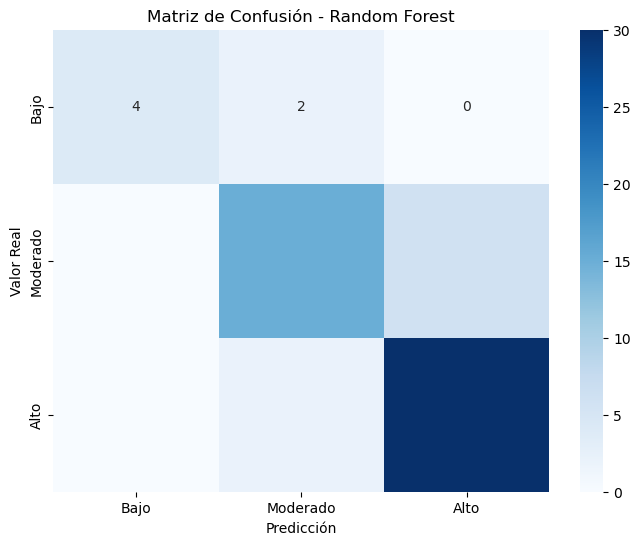


----------------------------------------------------------------------
IMPORTANCIA DE CARACTERÍSTICAS
----------------------------------------------------------------------
         Característica  Importancia
DiagnosticoPrevioCancer     0.310772
  FamiliarPrimerGradoCC     0.194045
                   Edad     0.191485
              Ejercicio     0.085229
                Alcohol     0.074505
             PrimerHijo     0.061463
             Mamografia     0.045685
 FamiliarSegundoGradoCC     0.036817
           Menstruacion     0.000000


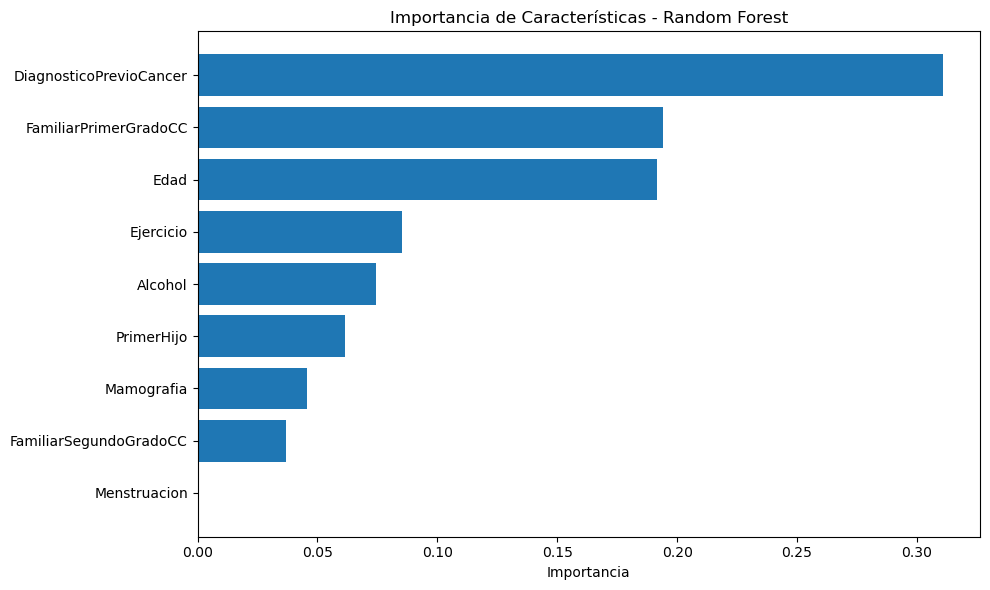


✓ Modelo guardado como 'modelo_random_forest.pkl'


In [38]:
# ============================================
# MODELO 1: RANDOM FOREST
# ============================================

print("\n" + "="*70)
print("ENTRENAMIENTO: RANDOM FOREST CLASSIFIER")
print("="*70)

# Entrenar modelo
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("\nEntrenando modelo...")
rf.fit(X_train, y_train)
print("Modelo entrenado exitosamente")

# Predicciones
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)

# --- MÉTRICAS ---
print("\n" + "="*70)
print("MÉTRICAS DE EVALUACIÓN - RANDOM FOREST")
print("="*70)

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy: {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")

# F1-Score (macro para multiclase)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print(f"F1-Score (macro): {f1_rf:.4f}")

# ROC AUC (One-vs-Rest para multiclase)
try:
    roc_auc_rf = roc_auc_score(y_test, y_proba_rf, multi_class='ovr', average='macro')
    print(f"ROC AUC (macro): {roc_auc_rf:.4f}")
except:
    roc_auc_rf = None
    print("ROC AUC: No calculable (posible clase sin muestras)")

# Reporte de clasificación detallado
print("\n" + "-"*70)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("-"*70)
print(classification_report(
    y_test, y_pred_rf,
    target_names=['Bajo', 'Moderado', 'Alto'],
    digits=4
))

# Matriz de confusión
print("MATRIZ DE CONFUSIÓN")
print("-"*70)
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bajo', 'Moderado', 'Alto'],
            yticklabels=['Bajo', 'Moderado', 'Alto'])
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

# Importancia de características
print("\n" + "-"*70)
print("IMPORTANCIA DE CARACTERÍSTICAS")
print("-"*70)
importancia_rf = pd.DataFrame({
    'Característica': X_train.columns,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

print(importancia_rf.to_string(index=False))

# Gráfico de importancia
plt.figure(figsize=(10, 6))
plt.barh(importancia_rf['Característica'], importancia_rf['Importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de Características - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Guardar modelo
joblib.dump(rf, 'modelo_random_forest.pkl')
print("\n✓ Modelo guardado como 'modelo_random_forest.pkl'")

# Almacenar métricas para comparación
metricas_rf = {
    'Modelo': 'Random Forest',
    'Accuracy': accuracy_rf,
    'F1-Score': f1_rf,
    'ROC AUC': roc_auc_rf if roc_auc_rf else 'N/A'
}


ENTRENAMIENTO: K-NEAREST NEIGHBORS (KNN)

K seleccionado: 15
Entrenando modelo...
Modelo entrenado exitosamente

MÉTRICAS DE EVALUACIÓN - KNN

Accuracy: 0.7797 (77.97%)
F1-Score (macro): 0.6699
ROC AUC (macro): 0.9074

----------------------------------------------------------------------
REPORTE DE CLASIFICACIÓN DETALLADO
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Bajo     0.6667    0.3333    0.4444         6
    Moderado     0.7000    0.6667    0.6829        21
        Alto     0.8333    0.9375    0.8824        32

    accuracy                         0.7797        59
   macro avg     0.7333    0.6458    0.6699        59
weighted avg     0.7689    0.7797    0.7668        59

MATRIZ DE CONFUSIÓN
----------------------------------------------------------------------
[[ 2  4  0]
 [ 1 14  6]
 [ 0  2 30]]


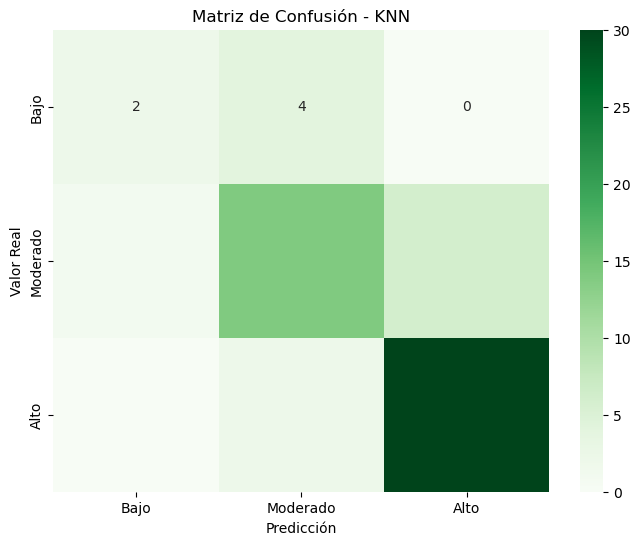


Modelo guardado como 'modelo_knn.pkl'


In [39]:
# ============================================
# MODELO 2: K-NEAREST NEIGHBORS (KNN)
# ============================================

print("\n" + "="*70)
print("ENTRENAMIENTO: K-NEAREST NEIGHBORS (KNN)")
print("="*70)

# Determinar K óptimo
k_value = max(3, int(np.sqrt(len(X_train))))
if k_value % 2 == 0:
    k_value += 1  # Hacer impar para evitar empates

print(f"\nK seleccionado: {k_value}")

# Entrenar modelo
knn = KNeighborsClassifier(
    n_neighbors=k_value,
    metric='euclidean',
    weights='distance'
)

print("Entrenando modelo...")
knn.fit(X_train, y_train)
print("Modelo entrenado exitosamente")

# Predicciones
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)

# --- MÉTRICAS ---
print("\n" + "="*70)
print("MÉTRICAS DE EVALUACIÓN - KNN")
print("="*70)

# Accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"\nAccuracy: {accuracy_knn:.4f} ({accuracy_knn*100:.2f}%)")

# F1-Score
f1_knn = f1_score(y_test, y_pred_knn, average='macro')
print(f"F1-Score (macro): {f1_knn:.4f}")

# ROC AUC
try:
    roc_auc_knn = roc_auc_score(y_test, y_proba_knn, multi_class='ovr', average='macro')
    print(f"ROC AUC (macro): {roc_auc_knn:.4f}")
except:
    roc_auc_knn = None
    print("ROC AUC: No calculable")

# Reporte de clasificación
print("\n" + "-"*70)
print("REPORTE DE CLASIFICACIÓN DETALLADO")
print("-"*70)
print(classification_report(
    y_test, y_pred_knn,
    target_names=['Bajo', 'Moderado', 'Alto'],
    digits=4
))

# Matriz de confusión
print("MATRIZ DE CONFUSIÓN")
print("-"*70)
cm_knn = confusion_matrix(y_test, y_pred_knn)
print(cm_knn)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Bajo', 'Moderado', 'Alto'],
            yticklabels=['Bajo', 'Moderado', 'Alto'])
plt.title('Matriz de Confusión - KNN')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.show()

# Guardar modelo
joblib.dump(knn, 'modelo_knn.pkl')
print("\nModelo guardado como 'modelo_knn.pkl'")

# Almacenar métricas
metricas_knn = {
    'Modelo': 'KNN',
    'Accuracy': accuracy_knn,
    'F1-Score': f1_knn,
    'ROC AUC': roc_auc_knn if roc_auc_knn else 'N/A'
}


ENTRENAMIENTO: K-MEANS CLUSTERING

Preparando datos para K-Means...
Valores nulos en X_kmeans: 0
Dimensiones de X_kmeans: (292, 9)

Entrenando modelo...
Modelo entrenado exitosamente

MÉTRICAS DE EVALUACIÓN - K-MEANS

Adjusted Rand Index: 0.0471
  (Mide similitud entre clusters y clases reales, -1 a 1)
Silhouette Score: 0.2107
  (Mide cohesión interna, -1 a 1, más alto es mejor)
Davies-Bouldin Index: 1.6040
  (Mide separación, más bajo es mejor)

----------------------------------------------------------------------
DISTRIBUCIÓN DE CLUSTERS
----------------------------------------------------------------------
  Cluster 0: 92 pacientes (31.5%)
  Cluster 1: 111 pacientes (38.0%)
  Cluster 2: 89 pacientes (30.5%)

----------------------------------------------------------------------
MAPEO CLUSTER → RIESGO (Heurística)
----------------------------------------------------------------------

Cluster 0:
  Riesgo Bajo: 5
  Riesgo Moderado: 33
  Riesgo Alto: 54

Cluster 1:
  Riesgo Bajo: 21


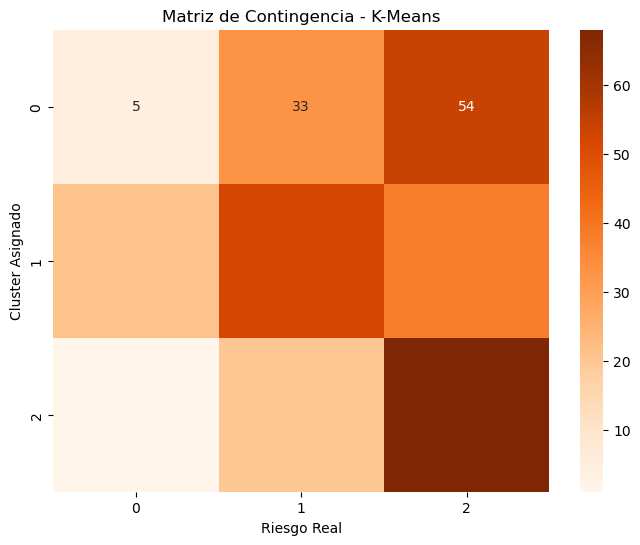

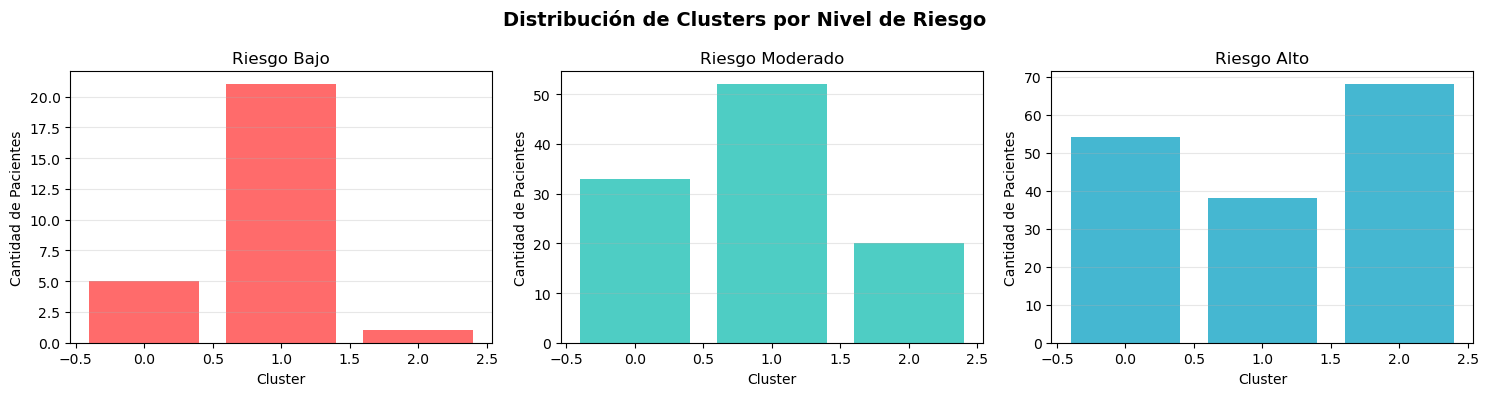


Modelo guardado como 'modelo_kmeans.pkl'

K-MEANS COMPLETADO EXITOSAMENTE


In [40]:
# ============================================
# MODELO 3: K-MEANS (CLUSTERING NO SUPERVISADO)
# ============================================

print("\n" + "="*70)
print("ENTRENAMIENTO: K-MEANS CLUSTERING")
print("="*70)

# --- PREPARAR DATOS COMPLETOS PARA K-MEANS ---
# K-Means necesita el dataset completo (X), no solo train/test
# Aplicamos la misma limpieza que hicimos en X_train y X_test

print("\nPreparando datos para K-Means...")

# Crear copia limpia de X
X_kmeans = X.copy()

# Reemplazar infinitos por NaN
X_kmeans = X_kmeans.replace([np.inf, -np.inf], np.nan)

# Función para obtener moda de forma segura
def obtener_moda_segura(serie, valor_defecto=0):
    """Obtiene la moda de una serie, o devuelve valor por defecto"""
    try:
        moda = serie.mode()
        return moda[0] if len(moda) > 0 else valor_defecto
    except:
        return valor_defecto

# Estrategia de imputación basada en la moda
valores_imputacion_kmeans = {}
for col in X_kmeans.columns:
    if X_kmeans[col].isnull().sum() > 0:
        valores_imputacion_kmeans[col] = obtener_moda_segura(X_kmeans[col], 0)

# Aplicar imputación
if valores_imputacion_kmeans:
    X_kmeans = X_kmeans.fillna(valores_imputacion_kmeans)
else:
    X_kmeans = X_kmeans.fillna(0)

# Convertir a numérico
for col in X_kmeans.columns:
    X_kmeans[col] = pd.to_numeric(X_kmeans[col], errors='coerce')

# Rellenar cualquier NaN generado por conversión
X_kmeans = X_kmeans.fillna(0)

# Verificación final
print(f"Valores nulos en X_kmeans: {X_kmeans.isnull().sum().sum()}")
print(f"Dimensiones de X_kmeans: {X_kmeans.shape}")

# --- ENTRENAR MODELO ---
kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10,
    max_iter=300
)

print("\nEntrenando modelo...")
kmeans.fit(X_kmeans)
print("Modelo entrenado exitosamente")

# Predicciones (todo el dataset)
labels_kmeans = kmeans.predict(X_kmeans)
df['Cluster'] = labels_kmeans

# --- MÉTRICAS ADAPTADAS PARA CLUSTERING ---
print("\n" + "="*70)
print("MÉTRICAS DE EVALUACIÓN - K-MEANS")
print("="*70)

# Para K-Means necesitamos comparar clusters con etiquetas reales
from sklearn.metrics import adjusted_rand_score, silhouette_score, davies_bouldin_score

# Adjusted Rand Index (similitud con etiquetas reales)
ari_kmeans = adjusted_rand_score(y, labels_kmeans)
print(f"\nAdjusted Rand Index: {ari_kmeans:.4f}")
print("  (Mide similitud entre clusters y clases reales, -1 a 1)")

# Silhouette Score (calidad de clustering)
silhouette_kmeans = silhouette_score(X_kmeans, labels_kmeans)
print(f"Silhouette Score: {silhouette_kmeans:.4f}")
print("  (Mide cohesión interna, -1 a 1, más alto es mejor)")

# Davies-Bouldin Index (separación de clusters)
db_kmeans = davies_bouldin_score(X_kmeans, labels_kmeans)
print(f"Davies-Bouldin Index: {db_kmeans:.4f}")
print("  (Mide separación, más bajo es mejor)")

# Distribución de clusters
print("\n" + "-"*70)
print("DISTRIBUCIÓN DE CLUSTERS")
print("-"*70)
for cluster in sorted(df['Cluster'].unique()):
    cantidad = (df['Cluster'] == cluster).sum()
    porcentaje = (cantidad / len(df)) * 100
    print(f"  Cluster {cluster}: {cantidad} pacientes ({porcentaje:.1f}%)")

# Mapeo de clusters a clases de riesgo (heurística)
print("\n" + "-"*70)
print("MAPEO CLUSTER → RIESGO (Heurística)")
print("-"*70)
for cluster in sorted(df['Cluster'].unique()):
    subset = df[df['Cluster'] == cluster]
    distribucion = subset['Riesgo'].value_counts().sort_index()
    print(f"\nCluster {cluster}:")
    for riesgo, cantidad in distribucion.items():
        etiqueta = ['Bajo', 'Moderado', 'Alto'][riesgo]
        print(f"  Riesgo {etiqueta}: {cantidad}")

# Matriz de confusión adaptada
print("\n" + "-"*70)
print("MATRIZ DE CONTINGENCIA (Cluster vs Riesgo Real)")
print("-"*70)
contingencia = pd.crosstab(df['Cluster'], df['Riesgo'])
print(contingencia)

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(contingencia, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Contingencia - K-Means')
plt.ylabel('Cluster Asignado')
plt.xlabel('Riesgo Real')
plt.show()

# Visualización adicional: Distribución de clusters por riesgo
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for riesgo in range(3):
    etiqueta_riesgo = ['Bajo', 'Moderado', 'Alto'][riesgo]
    subset = df[df['Riesgo'] == riesgo]
    cluster_counts = subset['Cluster'].value_counts().sort_index()
    
    axes[riesgo].bar(cluster_counts.index, cluster_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'][riesgo])
    axes[riesgo].set_title(f'Riesgo {etiqueta_riesgo}')
    axes[riesgo].set_xlabel('Cluster')
    axes[riesgo].set_ylabel('Cantidad de Pacientes')
    axes[riesgo].grid(axis='y', alpha=0.3)

plt.suptitle('Distribución de Clusters por Nivel de Riesgo', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Guardar modelo
joblib.dump(kmeans, 'modelo_kmeans.pkl')
print("\nModelo guardado como 'modelo_kmeans.pkl'")

# Almacenar métricas (adaptadas para clustering)
metricas_kmeans = {
    'Modelo': 'K-Means',
    'Adjusted Rand Index': ari_kmeans,
    'Silhouette Score': silhouette_kmeans,
    'Davies-Bouldin': db_kmeans
}

print("\n" + "="*70)
print("K-MEANS COMPLETADO EXITOSAMENTE")
print("="*70)


TABLA COMPARATIVA DE MODELOS

MODELOS SUPERVISADOS:
       Modelo  Accuracy  F1-Score  ROC AUC        Tipo
Random Forest  0.830508  0.810784 0.954454 Supervisado
          KNN  0.779661  0.669908 0.907357 Supervisado

MODELO NO SUPERVISADO:
K-Means:
  - Adjusted Rand Index: 0.0471
  - Silhouette Score: 0.2107
  - Davies-Bouldin Index: 1.6040

RESUMEN Y RECOMENDACIÓN

MEJOR MODELO SUPERVISADO: Random Forest
   - Accuracy: 0.8305
   - F1-Score: 0.8108
   - ROC AUC: 0.9544539086185063

ARCHIVOS GENERADOS:
   modelo_random_forest.pkl
   modelo_knn.pkl
   modelo_kmeans.pkl

ENTRENAMIENTO COMPLETADO EXITOSAMENTE


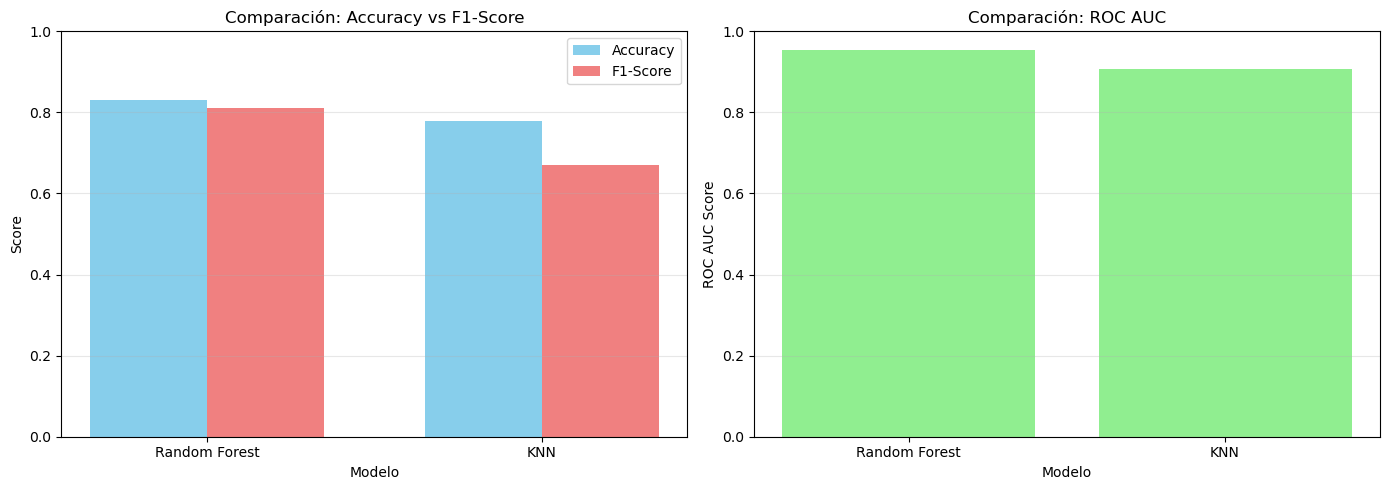

In [41]:
# ============================================
# COMPARACIÓN FINAL DE MODELOS
# ============================================

print("\n" + "="*70)
print("TABLA COMPARATIVA DE MODELOS")
print("="*70)

# Tabla de modelos supervisados
df_comparacion_supervisados = pd.DataFrame([metricas_rf, metricas_knn])
df_comparacion_supervisados['Tipo'] = 'Supervisado'

print("\nMODELOS SUPERVISADOS:")
print(df_comparacion_supervisados.to_string(index=False))

# Tabla de K-Means (separada por métricas diferentes)
print("\nMODELO NO SUPERVISADO:")
print(f"K-Means:")
print(f"  - Adjusted Rand Index: {metricas_kmeans['Adjusted Rand Index']:.4f}")
print(f"  - Silhouette Score: {metricas_kmeans['Silhouette Score']:.4f}")
print(f"  - Davies-Bouldin Index: {metricas_kmeans['Davies-Bouldin']:.4f}")

# Determinar mejor modelo supervisado
mejor_modelo = df_comparacion_supervisados.loc[
    df_comparacion_supervisados['Accuracy'].idxmax()
]

print("\n" + "="*70)
print("RESUMEN Y RECOMENDACIÓN")
print("="*70)
print(f"\nMEJOR MODELO SUPERVISADO: {mejor_modelo['Modelo']}")
print(f"   - Accuracy: {mejor_modelo['Accuracy']:.4f}")
print(f"   - F1-Score: {mejor_modelo['F1-Score']:.4f}")
print(f"   - ROC AUC: {mejor_modelo['ROC AUC']}")

print("\nARCHIVOS GENERADOS:")
print("   modelo_random_forest.pkl")
print("   modelo_knn.pkl")
print("   modelo_kmeans.pkl")

print("\nENTRENAMIENTO COMPLETADO EXITOSAMENTE")
print("="*70)

# Gráfico comparativo
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Accuracy y F1-Score
modelos = df_comparacion_supervisados['Modelo']
x = np.arange(len(modelos))
width = 0.35

ax[0].bar(x - width/2, df_comparacion_supervisados['Accuracy'], width, label='Accuracy', color='skyblue')
ax[0].bar(x + width/2, df_comparacion_supervisados['F1-Score'], width, label='F1-Score', color='lightcoral')
ax[0].set_xlabel('Modelo')
ax[0].set_ylabel('Score')
ax[0].set_title('Comparación: Accuracy vs F1-Score')
ax[0].set_xticks(x)
ax[0].set_xticklabels(modelos)
ax[0].legend()
ax[0].set_ylim([0, 1])
ax[0].grid(axis='y', alpha=0.3)

# Gráfico 2: ROC AUC (si está disponible)
roc_values = []
roc_labels = []
for _, row in df_comparacion_supervisados.iterrows():
    if row['ROC AUC'] != 'N/A':
        roc_values.append(row['ROC AUC'])
        roc_labels.append(row['Modelo'])

if roc_values:
    ax[1].bar(roc_labels, roc_values, color='lightgreen')
    ax[1].set_xlabel('Modelo')
    ax[1].set_ylabel('ROC AUC Score')
    ax[1].set_title('Comparación: ROC AUC')
    ax[1].set_ylim([0, 1])
    ax[1].grid(axis='y', alpha=0.3)
else:
    ax[1].text(0.5, 0.5, 'ROC AUC no disponible', 
               ha='center', va='center', fontsize=12)
    ax[1].set_title('ROC AUC')

plt.tight_layout()
plt.show()